In [ ]:
import os
import pandas as pd
import numpy as np
from DataPreprocessing import RF_DataPreprocessing
from FeatureEngineering import RF_FeatureEngineering
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# 1. Read Data and preprocess

In [2]:
'''Define dataset and process dataset'''
# Define database path
path = 'dataset.xlsx'
# Read and process database 
# dataset dictionary = {property:[feature, target property],...}
data = pd.read_excel(path)
preprocessed_data = RF_DataPreprocessing(data)
# Find common low-VI features from all three properties & drop them from data
low_VI_dropped_data, grouped_VIs = RF_FeatureEngineering(preprocessed_data)

Common low VI features: {'Ga', 'Pb', 'B', 'Ni', 'Be', 'Bi', 'V'}


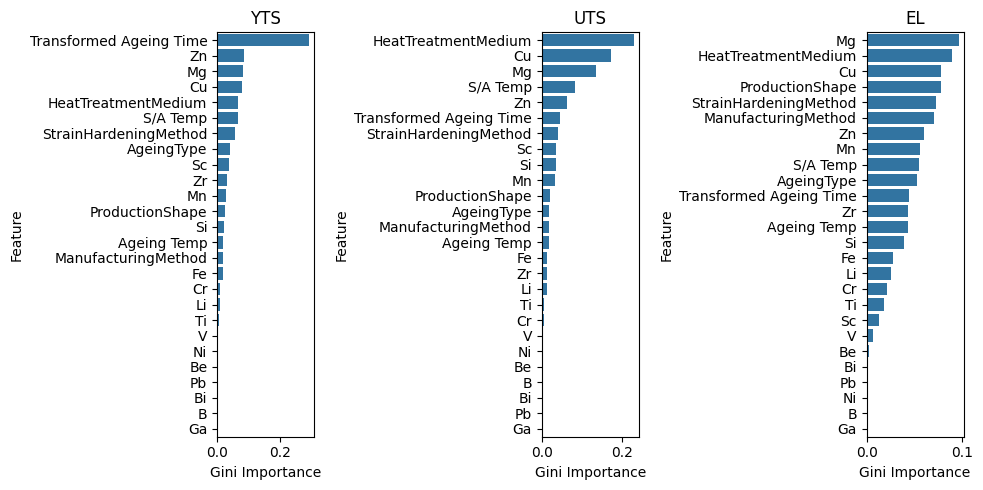

In [3]:
import seaborn as sns
# vis group_VIs, format {property:[feature, importance]}
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

for property_name, vi_data in grouped_VIs.items():
    # sort vi_data by importance
    vi_data.sort(key=lambda x: x[1], reverse=True)
    features, importances = zip(*vi_data)
    plt.subplot(1, len(grouped_VIs), list(grouped_VIs.keys()).index(property_name) + 1)
    sns.barplot(x=importances, y=features)
    plt.title(property_name)
    plt.xlabel('Gini Importance')
    plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# 2. Model Selection

In [4]:
# model settings
Model = ['RF', 'XGB', 'SVR']
Regressor = {'RF': RandomForestRegressor(),
             'XGB': XGBRegressor(),
             'SVR': SVR(kernel='rbf')}
# Model parameters for Grid Search
Model_para = {'RF': {'n_estimators': [50, 100, 200, 500],
                      'max_depth': [None, 5, 10, 20],
                      'min_samples_split': [2, 4, 8],
                      'min_samples_leaf': [1, 2, 4]},
              'XGB': {'n_estimators': [50, 100, 200, 500],
                      'max_depth': [2, 4, 8],
                      'learning_rate': [0.05, 0.1, 0.2, 0.5]},
              'SVR': {'C': [100,200,300,400,500,600,700,800,900,1000],
                      'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}}

In [5]:
#  Grid Search for best parameters based on k-fold cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
K = 5
seed_num = 100
model_score = {}

for model in Model:
    regressor = Regressor[model]
    param_grid = Model_para[model]
    
    print('==================================================================================================')
    print('Model: ', model)
    for prop in low_VI_dropped_data:
        X = low_VI_dropped_data[prop][0]
        y = low_VI_dropped_data[prop][1]
        grid_search = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = K, n_jobs = -1, scoring = 'neg_mean_absolute_error')
        grid_search.fit(X, y)
        best_para = grid_search.best_params_
        #  Test the model with best parameters
        best_model = grid_search.best_estimator_
        kfold = KFold(n_splits = K, random_state = 42, shuffle = True)
        scores = -cross_val_score(best_model, X, y, scoring = 'neg_mean_absolute_error', cv = kfold, n_jobs = -1)
        r2 = cross_val_score(best_model, X, y, scoring = 'r2', cv = kfold, n_jobs = -1)
        mse = -cross_val_score(best_model, X, y, scoring = 'neg_mean_squared_error', cv = kfold, n_jobs = -1)
        print('--------------------------------------------------------------------------------------------------')
        print('Property: ', prop)
        print('Optimal parameters: ', best_para)
        print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
        print('Mean R2: %.3f (%.3f)' % (np.mean(r2), np.std(r2)))
        print('Mean MSE: %.3f (%.3f)' % (np.mean(mse), np.std(mse)))


Model:  RF
--------------------------------------------------------------------------------------------------
Property:  YTS
Optimal parameters:  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 50}
Mean MAE: 27.465 (4.147)
Mean R2: 0.897 (0.043)
Mean MSE: 2193.782 (964.567)
--------------------------------------------------------------------------------------------------
Property:  UTS
Optimal parameters:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 200}
Mean MAE: 21.547 (1.209)
Mean R2: 0.953 (0.006)
Mean MSE: 1127.530 (164.368)
--------------------------------------------------------------------------------------------------
Property:  EL
Optimal parameters:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 50}
Mean MAE: 3.351 (0.282)
Mean R2: 0.575 (0.071)
Mean MSE: 26.440 (5.605)
Model:  XGB
-----------------------------------------------------------------------------------------